In [124]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import grad, jit, vmap, jacfwd, jacrev, random
from jax.scipy.linalg import cholesky, solve_triangular


My implementation for the heat equation using just analytical solutions of the derivatives had some issues. I will try to implement the heat equation into the kernel using jax.    
The heat equation in one dimension is given by:
$$\frac{\partial u}{\partial t} - \alpha \frac{\partial^2 u}{\partial x^2} = f(x,t)$$
where $\alpha$ is the thermal diffusivity. I took the analytical solution from the paper [Raissi](https://www.sciencedirect.com/science/article/pii/S0021999117305582?via%3Dihub) and I try to reproduce the same results. One solution for $\alpha$ = 1 is given by:
\begin{equation}
\begin{aligned}
f(x,t) &= \exp{(-t)}(4 \pi - 1)\sin{(2\pi x)} \\     
u(x,t) &= \exp{(-t)}\sin{(2\pi x)}
\end{aligned}
\end{equation}
I will now sample some data from this solution and plot the data. I will add some gaussian noise to the data, mainly for stability reasons and to to simulate real world meassured data.

Text(0.5, 0, 'f(t,x)')

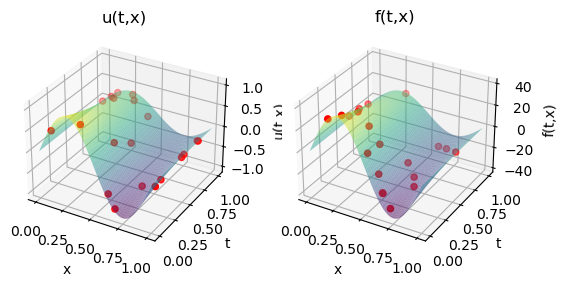

In [49]:
def get_data_set(n_training_points,noise):
    def f(t,x):
        return np.exp(-t)*np.sin(2*np.pi*x) *(4*np.pi**2 - 1)
    def u(t,x):
        return np.exp(-t)*np.sin(2*np.pi*x)
    
    #alpha = 2
    # def f(t, x):
    #     return np.exp(-t) * np.sin(2 * np.pi * x) * (8 * np.pi**2 - 1)

    # def u(t, x):
    #     return np.exp(-t) * np.sin(2 * np.pi * x)

    # create the training data u
    rng_u = np.random.default_rng(seed=28)
    t_u = rng_u.uniform(0,1,n_training_points).reshape(-1,1)
    x_u = rng_u.uniform(0,1,n_training_points).reshape(-1,1)
    #t_u = np.sort(t_u).reshape(-1,1)
    #x_u = np.sort(x_u).reshape(-1,1)
    u_values = u(t_u,x_u).reshape(-1,1) + np.random.normal(0, noise[0], u(t_u,x_u).shape)
    
    # create the training data f
    rng_f = np.random.default_rng(seed=20)
    t_f = rng_f.uniform(0,1,n_training_points).reshape(-1,1)
    x_f = rng_f.uniform(0,1,n_training_points).reshape(-1,1)
    #t_f = np.sort(t_f).reshape(-1,1)
    #x_f = np.sort(x_f).reshape(-1,1)
    f_values = f(t_f,x_f).reshape(-1,1) + np.random.normal(0, noise[1], u(t_u,x_u).shape)
    return u_values, f_values, t_u, x_u, t_f, x_f
noise = [0.00001,0.00001]
u_train, f_train, t_u, x_u, t_f, x_f = get_data_set(20,noise)
t = np.linspace(0,1,100)
x = np.linspace(0,1,100)
t_mesh, x_mesh = np.meshgrid(t,x)
u_mesh = np.exp(-t_mesh)*np.sin(2*np.pi*x_mesh)
f_mesh = np.exp(-t_mesh)*np.sin(2*np.pi*x_mesh) *(4*np.pi**2 - 1)

#plot the data in a 3d plot
fig, ax = plt.subplots(1,2,subplot_kw={"projection": "3d"})
ax[0].plot_surface(x_mesh, t_mesh, u_mesh, cmap='viridis', edgecolor='none', alpha=0.5)
ax[0].scatter(x_u, t_u, u_train, c='r', marker='o')
ax[0].set_title('u(t,x)')
ax[0].set_xlabel('x')
ax[0].set_ylabel('t')
ax[0].set_zlabel('u(t,x)')
ax[1].plot_surface(x_mesh, t_mesh, f_mesh, cmap='viridis', edgecolor='none', alpha=0.5)
ax[1].scatter(x_f, t_f, f_train, c='r', marker='o')
ax[1].set_title('f(t,x)')
ax[1].set_xlabel('x')
ax[1].set_ylabel('t')
ax[1].set_zlabel('f(t,x)')


The next step is to implement the kernel for the heat equation. I will use the same kernel as in the paper, so just the RBF kernel. Our linear operator is given by:
$$\mathcal{L}_x ^\alpha = \frac{\partial}{\partial t} - \alpha \frac{\partial^2}{\partial x^2}$$    
We need 4 different parts for the kernel:
1. The kernel without the linear operator $K(x,y,t,s)_{uu}$
2. The kernel with one $K_{uf}$ = $\mathcal{L}_{y}^\alpha$ $K_{uu}$
3. The kernel with one $K_{fu}$ = $\mathcal{L}_x^\alpha$ $K_{uu}$
4. And with both transformations $K_{ff}$ = $\mathcal{L}_x^\alpha$ $\mathcal{L}_y^\alpha$ $K_{uu}$
The first kernel is just the normal RBF kernel: 
\begin{align}
K(x,y,t,s)_{uu} = \sigma_f^2 e^{-\gamma_x(x-y)^2 - \gamma_t(t-s)^2}
\end{align}
For the second we use the linear operator once with respect to y and s.
\begin{align}
K_{uf} = \mathcal{L}_{y}^\alpha K_{uu} = \frac{\partial}{\partial s} K_{uu} - \alpha \frac{\partial^2}{\partial y^2} K_{uu}
\end{align}
Same for the third kernel, but with respect to x and t.
\begin{align}
K_{fu} = \mathcal{L}_{x}^\alpha K_{uu} = \frac{\partial}{\partial t} K_{uu} - \alpha \frac{\partial^2}{\partial x^2} K_{uu}
\end{align}
And for the last kernel we use the linear operator twice.
\begin{align}
K_{ff} = \mathcal{L}_{x}^\alpha \mathcal{L}_{y}^\alpha K_{uu} = \frac{\partial^2}{\partial t \partial s} K_{uu} + \alpha^2 \frac{\partial^2}{\partial x^2} \frac{\partial^2}{\partial y^2} K_{uu}
\end{align}
The implementation was very hard at the start, so I had to split the starting kernel into two parts, one for xy and one for ts. I just use the $\sigma_f$ parameter once in the x kernel. But I will multiply the two kernels anyways, so it should not make a difference.

In [23]:
@jit
def rbf_kernel_single_x(x, y, params):
    l, sigma_f_sq = params[0], params[1]
    sqdist = jnp.sum(x-y)**2
    return sigma_f_sq * jnp.exp(-0.5 / l**2 * sqdist)
@jit
def rbf_kernel_single_t(t, s, l_t):
    sqdist = jnp.sum(t-s)**2
    value = jnp.exp(-0.5 / l_t**2 * sqdist)
    return value

In [24]:
@jit
def k_uu(X, Y, T, S, params):
    vectorized_rbf_kernel_x = vmap(vmap(rbf_kernel_single_x, (None, 0, None)), (0, None, None))
    vectorized_rbf_kernel_t = vmap(vmap(rbf_kernel_single_t, (None, 0, None)), (0, None, None))
    alpha = params[-1]
    params = params[:-1]
    return vectorized_rbf_kernel_x(X, Y, params) * vectorized_rbf_kernel_t(T, S, params[2])

In [25]:
@jit
def k_ff(X, Y, T, S, params):
    # params = [l_x, sigma_f_sq, l_t, alpha]
    alpha = params[-1]
    params = params[:-1]
    X,Y,T,S = X.flatten(), Y.flatten(), T.flatten(), S.flatten() #this is not my favourite solution, but it works atm. However there still is a problem with multidimesional data
    # first I vectorize both the kernel functions seperately
    vectorized_rbf_kernel_x = vmap(vmap(rbf_kernel_single_x, (None, 0, None)), (0, None, None))
    vectorized_rbf_kernel_t = vmap(vmap(rbf_kernel_single_t, (None, 0, None)), (0, None, None))
    # now I compute the derivatives seperately and then multiply by the other kernel. This should be reasonable, because the other kernel is not dependent on the derivative.
    dk_dtds = grad(grad(rbf_kernel_single_t, argnums = 1), argnums = 0)
    vectorized_dtds = vmap(vmap(dk_dtds, (None, 0, None)), (0, None, None))

    dk_dydy = grad(grad(rbf_kernel_single_x, argnums = 1), argnums = 1) # this is both the second derivative of the kernel with respect y
    dk_dxdxdydy = grad(grad(dk_dydy, argnums = 0), argnums = 0) # this is both the second derivative of the kernel with respect to x and y
    vectorized_dxdxdydy = vmap(vmap(dk_dxdxdydy, (None, 0, None)), (0, None, None))

    #first part of the kernel
    first_part = vectorized_dtds(T,S,params[2]) * vectorized_rbf_kernel_x(X,Y,params) 
    #second part of the kernel
    second_part = vectorized_dxdxdydy(X,Y,params) * vectorized_rbf_kernel_t(T,S,params[2]) 
    return first_part + alpha**2 * second_part

x = np.linspace(0,1,100).reshape(-1,1)
t = np.linspace(0,1,100).reshape(-1,1)
y = np.linspace(0,2,100).reshape(-1,1)
s = np.linspace(0,1,100).reshape(-1,1)
params = [1,1,1,1]
k_ff(x,y,t,s,params).shape

(100, 100)

In [26]:
@jit
def k_uf(X, Y, T, S, params):
    """computes the cross kernel k_uf"""
    
    alpha = params[-1]
    params = params[:-1]
    X,Y,T,S = X.flatten(), Y.flatten(), T.flatten(), S.flatten() #this is not my favourite solution, but it works atm. However there still is a problem with multidimesional data
    # first I vectorize both the kernel functions seperately
    vectorized_rbf_kernel_x = vmap(vmap(rbf_kernel_single_x, (None, 0, None)), (0, None, None))
    vectorized_rbf_kernel_t = vmap(vmap(rbf_kernel_single_t, (None, 0, None)), (0, None, None))
    # dk/ds
    dk_ds = grad(rbf_kernel_single_t, argnums = 1)
    vectorized_dk_ds = vmap(vmap(dk_ds, (None, 0, None)), (0, None, None))

    # dk/dy^2
    dk_dydy = grad(grad(rbf_kernel_single_x, argnums = 1), argnums = 1) # this is both the second derivative of the kernel with respect y
    vectorized_dk_dydy = vmap(vmap(dk_dydy, (None, 0, None)), (0, None, None))
    
    first_part = vectorized_dk_ds(T,S,params[2]) * vectorized_rbf_kernel_x(X,Y,params)
    second_part = vectorized_dk_dydy(X,Y,params) * vectorized_rbf_kernel_t(T,S,params[2])
    return first_part - alpha * second_part
print(k_uf(x,y,t,s,params).shape)

(100, 100)


In [27]:
@jit
def k_fu(X, Y, T, S, params):
    """computes the cross kernel k_fu the same as k_uf only the variable is different(argnums = 0)"""
    alpha = params[-1]
    params = params[:-1]
    X,Y,T,S = X.flatten(), Y.flatten(), T.flatten(), S.flatten() #this is not my favourite solution, but it works atm. However there still is a problem with multidimesional data
    # first I vectorize both the kernel functions seperately
    vectorized_rbf_kernel_x = vmap(vmap(rbf_kernel_single_x, (None, 0, None)), (0, None, None))
    vectorized_rbf_kernel_t = vmap(vmap(rbf_kernel_single_t, (None, 0, None)), (0, None, None))
    # dk/dt
    dk_dt = grad(rbf_kernel_single_t, argnums = 0)
    vectorized_dk_dt = vmap(vmap(dk_dt, (None, 0, None)), (0, None, None))

    # dk/dx^2
    dk_dxdx = grad(grad(rbf_kernel_single_x, argnums = 0), argnums = 0) # this is both the second derivative of the kernel with respect y
    vectorized_dk_dxdx = vmap(vmap(dk_dxdx, (None, 0, None)), (0, None, None))

    first_part = vectorized_dk_dt(T,S,params[2]) * vectorized_rbf_kernel_x(X,Y,params)
    second_part = vectorized_dk_dxdx(X,Y,params) * vectorized_rbf_kernel_t(T,S,params[2])
    return first_part - alpha * second_part


The gram matrix $K$ is given by:
\begin{align}
K = 
\begin{bmatrix}
K_{uu}(X_u,X_u) + \sigma_u^2 I & K_{uf}(X_u,X_f) \\
K_{fu}(X_f,X_u) & K_{ff}(X_f,X_f) + \sigma_f^2 I
\end{bmatrix}
\end{align}
Then we want to minimize the negative log likelihood:
\begin{align}
\mathcal{L} = \frac{1}{2} \log{|K|} + \frac{1}{2} y^T K^{-1} y + \frac{N}{2} \log{2\pi}
\end{align}
with $y = \begin{bmatrix} y_u \\ y_f \end{bmatrix}$ and $n$ is the number of data points.
  

In [135]:
@jit
def gram_Matrix(X, Y, T, S, params, noise_u = 0.00001, noise_f = 0.00001):
    """computes the gram matrix of the kernel"""
    k_uu_matrix = k_uu(X, X, T, T, params) + noise_u * jnp.eye(len(X))
    k_uf_matrix = k_uf(X, Y, T, S, params)
    k_fu_matrix = k_fu(Y, X, S, T, params) 
    k_ff_matrix = k_ff(Y, Y, S, S, params) + noise_f * jnp.eye(len(Y))
    K = jnp.block([[k_uu_matrix, k_uf_matrix], [k_fu_matrix, k_ff_matrix]])
    #ensure_psd(K)
    return K
print(np.linalg.eigvals(gram_Matrix(x_u, x_f, t_u, t_f, params))[np.where(np.linalg.eigvals(gram_Matrix(x_u, x_f, t_u, t_f, params)) < 0)])


[]


In [136]:
%timeit gram_Matrix(x_u, x_f, t_u, t_f, params)

2.58 ms ± 101 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
from scipy.optimize import minimize
from tqdm import tqdm
targets_train = jnp.vstack((u_train,f_train))

def log_marginal_likelihood(Kernel:callable, X, Y, T, S, targets, params):
    #gamma, sigma_f, nu = hyperparams[0],hyperparams[1],hyperparams[2
    K = Kernel(X, Y, T, S, params, noise_u = noise[0], noise_f = noise[1])
    
    L = jnp.linalg.cholesky(K)
    alpha = jnp.linalg.solve(L.T, jnp.linalg.solve(L, targets))
    mll = 1/2 * jnp.dot(targets.T,alpha) +0.5*jnp.sum(jnp.log(jnp.diagonal(L))) + len(K)/2 * jnp.log(2*jnp.pi)
    return jnp.squeeze(mll)

hyperparameters = [0.1,.1,1,1]
#print(log_marginal_likelihood(gram_Matrix, x_u, x_f, t_u, t_f, targets_train, hyperparameters))

def log_marginal_likelihood_to_optimize(Kernel:callable,  X, Y, T, S, targets):
    def function_to_optimize(hyperparams):
        mll = log_marginal_likelihood(Kernel, X, Y, T, S, targets, hyperparams)
        return mll
    return function_to_optimize


def optimization_restarts(Kernel: callable,n_restarts, X, Y, T, S, targets):
    best_mll = np.inf
    best_theta = np.zeros((4))
    best_result = None
    for i in tqdm(range(n_restarts)):
        rng = np.random.default_rng()
        theta_initial = rng.uniform(0,1,4)
        res = minimize(log_marginal_likelihood_to_optimize(Kernel, X, Y, T, S, targets), x0=theta_initial,
                       method='L-BFGS-B', bounds=((1e-5, 10), (1e-5, 10), (1e-5, 10),(1e-3, 10)),
                       options={'gtol': 1e-6})
                    
        if res.fun < best_mll:
            best_mll = res.fun
            best_theta = res.x
            best_result = res
    return res



res = optimization_restarts(gram_Matrix, 100, x_u, x_f, t_u, t_f, targets_train)

print("sigma_f, l_x, l_t, alpha")
print(res)
print("best mll")
print(res.fun)

In [196]:
print(res)

      fun: 4349.4501953125
 hess_inv: array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]])
      jac: array([0., 0., 0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 30
      nit: 1
     njev: 6
   status: 0
  success: True
        x: array([0.37636916, 0.31081717, 0.40676277, 0.68342202])


In [206]:
from joblib import Parallel, delayed

def optimization_restarts_parallel(Kernel: callable, n_restarts, X, Y, T, S, targets):
    best_mll = np.inf
    best_theta = np.zeros((4))
    best_result = None

    
    def single_optimization_run(Kernel, X, Y, T, S, targets):
        rng = np.random.default_rng()
        theta_initial = rng.uniform(0, 1, 4)
        res = minimize(log_marginal_likelihood_to_optimize(Kernel, X, Y, T, S, targets), x0=theta_initial,
                       method='L-BFGS-B', bounds=((1e-5, None), (1e-5, None), (1e-5, None),(1e-3, None)),
                       options={'gtol': 1e-6})
        return res

    
    results = Parallel(n_jobs=-1)(delayed(single_optimization_run)(Kernel, X, Y, T, S, targets) for _ in range(n_restarts))

    
    for res in results:
        if res.fun < best_mll:
            best_mll = res.fun
            best_theta = res.x
            best_result = res

    return best_result
res = optimization_restarts_parallel(gram_Matrix, 1500, x_u, x_f, t_u, t_f, targets_train)
print(res)

KeyboardInterrupt: 

The optimization process is still not really working that well. I need to find a better way and maybe build an optimization routine from scratch.   

[0.28386429 0.21461325 0.60349051 0.98713985] 

In [204]:
#just one good solution so i dont have to run the optimization again
res = [0.31604217, 0.97715365, 0.66528261, 0.9957155 ]

Now we calculate the predictive mean $f_*$ and the predictive variance $s^2_*$:

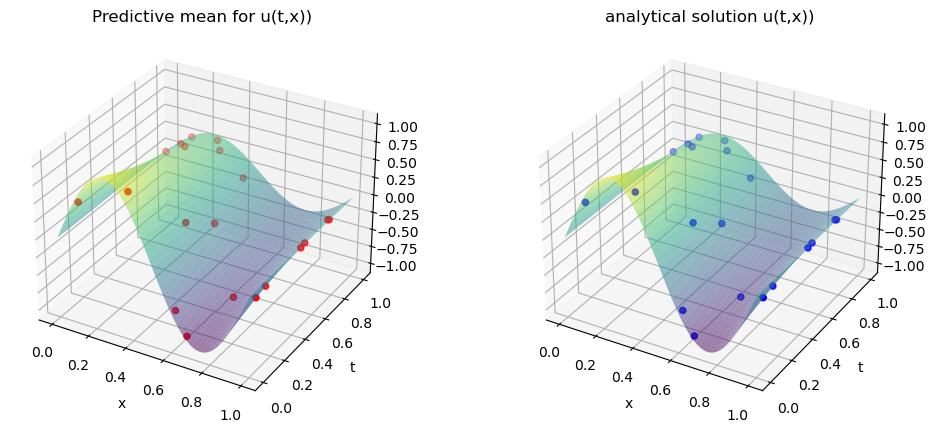

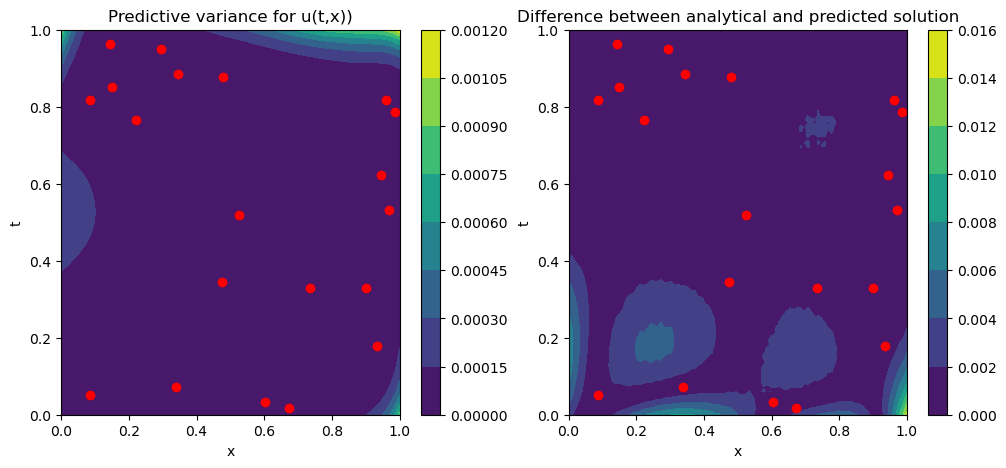

In [192]:
X_test = np.linspace(0,1,100).reshape(-1,1)
t_test = np.linspace(0,1,100).reshape(-1,1)
x_star, t_star = np.meshgrid(X_test, t_test)
x_star = x_star.reshape(-1,1)
t_star = t_star.reshape(-1,1)
targets = np.vstack((u_train, f_train))

L = jnp.linalg.cholesky(gram_Matrix(x_u, x_f, t_u, t_f, res.x))
q_1 = k_uu(x_star,x_u,t_star,t_u,res.x) 
q_2 = k_uf(x_star,x_f,t_star,t_f, res.x) 
q = jnp.hstack((q_1,q_2))
alpha = jnp.linalg.solve(L.T, jnp.linalg.solve(L, targets))
f_star = q@alpha
f_star = f_star.reshape(100,100)

alpha_var = np.linalg.solve(L.T, np.linalg.solve(L, q.T))
var = k_uu(x_star,x_star,t_star,t_star, res.x) - q@alpha_var
var = np.diag(var)
var = var.reshape(100,100)

analytical_solution = np.exp(-t_star)*np.sin(2*np.pi*x_star)

fig, ax = plt.subplots(1,2,subplot_kw={"projection": "3d"},figsize=(12,5))

ax[0].plot_surface(x_star.reshape(100,100), t_star.reshape(100,100), f_star, cmap='viridis', edgecolor='none', alpha=0.5)
ax[1].plot_surface(x_star.reshape(100,100), t_star.reshape(100,100), analytical_solution.reshape(100,100), cmap="viridis", edgecolor='none', alpha=0.5)
ax[0].set_title('Predictive mean for u(t,x))')
ax[0].set_xlabel('x')
ax[0].set_ylabel('t')
ax[0].scatter(x_u, t_u, u_train, c='r', marker='o')
ax[1].scatter(x_u, t_u, u_train, c='b', marker='o')
ax[1].set_title('analytical solution u(t,x))')
ax[1].set_xlabel('x')
ax[1].set_ylabel('t')
plt.show()

fig, ax = plt.subplots(1,2,figsize=(12,5))
cont1 = ax[0].contourf(x_star.reshape(100,100), t_star.reshape(100,100), var, cmap='viridis')
ax[0].scatter(x_u, t_u, c='r', marker='o')
ax[0].set_title('Predictive variance for u(t,x))')
ax[0].set_xlabel('x')
ax[0].set_ylabel('t')
fig.colorbar(cont1, ax=ax[0])


difference_analytical_predicted_solution = np.abs(analytical_solution.reshape(100,100) - f_star)

cont2 = ax[1].contourf(x_star.reshape(100,100), t_star.reshape(100,100), difference_analytical_predicted_solution, cmap='viridis')
ax[1].set_title('Difference between analytical and predicted solution')
ax[1].scatter(x_u, t_u, c='r', marker='o')
ax[1].set_xlabel('x')
ax[1].set_ylabel('t')
fig.colorbar(cont2, ax=ax[1])

Same thing for the forcing term $f(x,t)$:

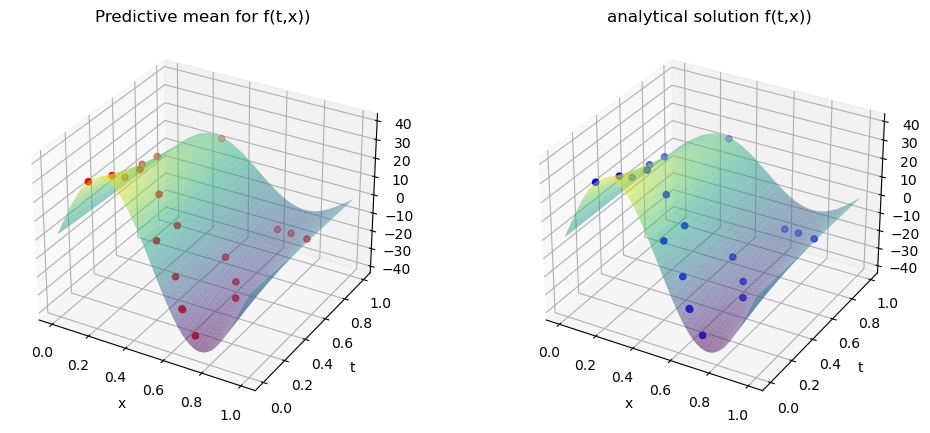

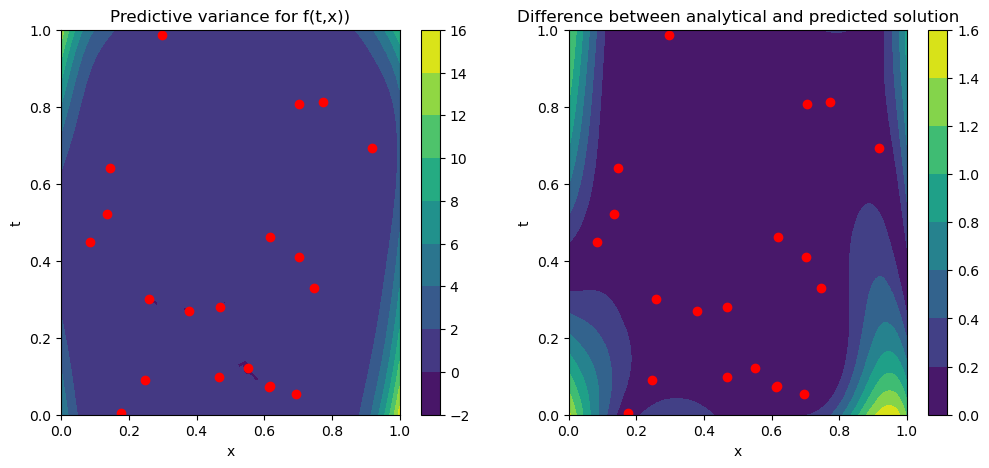

In [193]:

L = jnp.linalg.cholesky(gram_Matrix(x_u, x_f, t_u, t_f, res.x))
q_1 = k_fu(x_star,x_u,t_star,t_u,res.x) 
q_2 = k_ff(x_star,x_f,t_star,t_f, res.x) 
q = jnp.hstack((q_1,q_2))
alpha = jnp.linalg.solve(L.T, jnp.linalg.solve(L, targets))
f_star = q@alpha
f_star = f_star.reshape(100,100)

alpha_var = np.linalg.solve(L.T, jnp.linalg.solve(L, q.T))
var = k_ff(x_star,x_star,t_star,t_star, res.x) - q@alpha_var
var = np.diag(var)
var = var.reshape(100,100)

analytical_solution = np.exp(-t_star)*np.sin(2*np.pi*x_star) *(4*np.pi**2 - 1)
fig, ax = plt.subplots(1,2,subplot_kw={"projection": "3d"},figsize=(12,5))

ax[0].plot_surface(x_star.reshape(100,100), t_star.reshape(100,100), f_star, cmap='viridis', edgecolor='none', alpha=0.5)
ax[1].plot_surface(x_star.reshape(100,100), t_star.reshape(100,100), analytical_solution.reshape(100,100), cmap="viridis", edgecolor='none', alpha=0.5)
ax[0].set_title('Predictive mean for f(t,x))')
ax[0].set_xlabel('x')
ax[0].set_ylabel('t')
ax[0].scatter(x_f, t_f, f_train, c='r', marker='o')
ax[1].scatter(x_f, t_f, f_train, c='b', marker='o')
ax[1].set_title('analytical solution f(t,x))')
ax[1].set_xlabel('x')
ax[1].set_ylabel('t')
plt.show()

fig, ax = plt.subplots(1,2,figsize=(12,5))
cont1 = ax[0].contourf(x_star.reshape(100,100), t_star.reshape(100,100), var, cmap='viridis')
ax[0].scatter(x_f, t_f, c='r', marker='o')
ax[0].set_title('Predictive variance for f(t,x))')
ax[0].set_xlabel('x')
ax[0].set_ylabel('t')
fig.colorbar(cont1, ax=ax[0])


difference_analytical_predicted_solution = np.abs(analytical_solution.reshape(100,100) - f_star)

cont2 = ax[1].contourf(x_star.reshape(100,100), t_star.reshape(100,100), difference_analytical_predicted_solution, cmap='viridis')
ax[1].set_title('Difference between analytical and predicted solution')
ax[1].scatter(x_f, t_f, c='r', marker='o')
ax[1].set_xlabel('x')
ax[1].set_ylabel('t')
fig.colorbar(cont2, ax=ax[1])

In [45]:
from sklearn.metrics.pairwise import rbf_kernel as rbf_kernel_sklearn
def dk_ff(X, X_bar, t, t_bar, gamma_x, gamma_t, alpha):
    n, m = X.shape[0], X_bar.shape[0]
    dk_ff = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            diff_X = X[i] - X_bar[j]
            diff_t = t[i] - t_bar[j]
            #first part d/dt d/dt' 
            first_part = 2*gamma_t - 4*gamma_t**2 * diff_t**2
            #second part alpha**2 d2/dx2 d2/dx2'
            second_part = 4*gamma_x**2*(4*gamma_x*diff_X**2*(gamma_x*diff_X**2-3)+3)
            dk_ff[i, j] = first_part + alpha**2 * second_part
    return  dk_ff 
def dk_uf(X, X_bar, t, t_bar, gamma_x, gamma_t, alpha):
    n, m = X.shape[0], X_bar.shape[0]
    dk_uf = np.zeros((n, m))

# Loop over each pair of points
    for i in range(n):
        for j in range(m):
            diff_X = X[i] - X_bar[j]  # Squared distance between points
            diff_t = t[i] - t_bar[j]  # Difference in time
        
        # Compute dk_uf for this pair of points
            dk_uf[i, j] = -alpha * (gamma_x**4 * diff_X**2 - 2*gamma_x) + 2*gamma_t * diff_t

    return  dk_uf 
def dk_fu(X, X_bar, t, t_bar, gamma_x, gamma_t, alpha):
    n, m = X.shape[0], X_bar.shape[0]
    dk_uf = np.zeros((n, m))

    for i in range(n):
        for j in range(m):
            diff_X = X[i] - X_bar[j]  
            diff_t = (t[i] - t_bar[j])
        
        # Compute dk_uf for this pair of points
            dk_uf[i, j] = -alpha * (gamma_x**4 * diff_X**2 - 2*gamma_x) - 2*gamma_t * diff_t

    return  dk_uf 


def kernel_rbf(X,X_bar,t,t_bar, gamma_x, gamma_t, sigma_f):
    return sigma_f**2 * rbf_kernel_sklearn(X,X_bar, gamma_x) * rbf_kernel_sklearn(t,t_bar, gamma_t)

def create_K_matrix(X_u, X_f, t_u, t_f,sigma_u, sigma_f, gamma_x, gamma_t,sigma_rbf, alpha):
    k_uu = kernel_rbf(X_u,X_u,t_u,t_u,gamma_x, gamma_t, sigma_rbf ) #+ sigma_u * np.eye(len(X_u))
    k_uf = kernel_rbf(X_u,X_f,t_u,t_f, gamma_x, gamma_t, sigma_rbf) * dk_uf(X_u,X_f,t_u,t_f, gamma_x, gamma_t, alpha) 
    k_fu = kernel_rbf(X_f,X_u,t_f,t_u, gamma_x, gamma_t, sigma_rbf) * dk_fu(X_f,X_u,t_f,t_u, gamma_x, gamma_t, alpha)
    k_ff = kernel_rbf(X_f,X_f,t_f,t_f, gamma_x, gamma_t, sigma_rbf) * dk_ff(X_f,X_f,t_f,t_f, gamma_x, gamma_t, alpha) #+ sigma_f * np.eye(len(X_f))
    K = np.block([[k_uu, k_uf], [k_fu, k_ff]])
    return K
np.linalg.eigvals(create_K_matrix(x_u, x_f, t_u, t_f, 0.001, 0.001, 1, 1, 1, 1))[np.where(np.linalg.eigvals(create_K_matrix(x_u, x_f, t_u, t_f, 0.001, 0.001, 1, 1, 1, 1)) < 0)]

array([-1.12685982e-02, -2.64302049e-05])

Ok so the k_uu and the k_ff are the same.

In [14]:
k_ff_vanilla = kernel_rbf(x_f,x_f,t_f,t_f, 0.5, 0.5, 1) * dk_ff(x_f,x_f,t_f,t_f, 0.5, 0.5, 1)
k_ff_jax = k_ff(x_f,x_f,t_f,t_f, [1,1,1,1]) 

print(np.allclose(k_ff_vanilla,k_ff_jax))
k_ff_jax = k_ff_jax + 0.00001 * np.eye(len(x_f))
np.linalg.eigvals(k_ff_jax)[np.where(np.linalg.eigvals(k_ff_jax) < 0)]

True


array([], dtype=float32)

In [15]:
k_uf_vanilla = kernel_rbf(x_u,x_f,t_u,t_f, 0.5, 0.5, 1) * dk_uf(x_u,x_f,t_u,t_f, 0.5, 0.5, 1)
k_uf_jax = k_uf(x_u,x_f,t_u,t_f, [1,1,1,1])
print((k_uf_vanilla-k_uf_jax).sum())
k_uf_jax = k_uf_jax + 0.001 * np.eye(len(x_u))
np.linalg.eigvals(k_uf_jax)[np.where(np.linalg.eigvals(k_uf_jax) < 0)]

42.14885


array([-0.8772931 +0.j        , -0.11591902+0.j        ,
       -0.0086245 +0.00752688j, -0.0086245 -0.00752688j], dtype=complex64)